In [1]:
from utility.utility_general import *
from utility.util_tf import *
from utility import util_tf
import utility.util_plot as Plots
from IPython.display import display
import image_generator, imp, ml_tools, plots_tools
imp.reload(image_generator)
imp.reload(ml_tools)
imp.reload(plots_tools)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, \
    roc_curve, auc
import seaborn as sns
import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

## Initializing variables

In [2]:
notebook_filename = 'train_cae_mlp_d9_encoder_9.ipynb'
gpu_n = 3
data_set_num = 9
mlp_nodes_p_layer = 13
epochs = 5
over_sample = True

design_num = {13: 1, 7:2}
design_num = design_num[mlp_nodes_p_layer]
data_set_path = data_path + f'/data_sets/data_set_{data_set_num}/'
result_dir = f'results/train_cae_mlp/encoder_9/'\
             + notebook_filename.split('.ipynb')[0]

random_state = 0
util_tf.random_seed(random_state)

tot_time_1 = datetime.now()
gpu_device = f'/device:GPU:{gpu_n}'
print(f'{"Executable": <15}: ', sys.executable)
print(f'{"Results": <15}: ', result_dir)

Executable     :  /home/adavar2/anaconda3/envs/tfgpu2/bin/python
Results        :  results/train_cae_mlp/encoder_9/train_cae_mlp_d9_encoder_9


## Configure GPU
* [Disable first GPU](https://www.tensorflow.org/api_docs/python/tf/config/set_visible_devices)
* [Restrict to first GPU](https://www.tensorflow.org/guide/gpu)

In [3]:
util_tf.tf_select_gpu(gpu_n)
makedirs(result_dir, exist_ok=True)

Total Num. GPUs Available:  6
6 Physical GPUs, 1 Logical GPU

Selected resources:
/physical_device:CPU:0
/physical_device:GPU:3


## Preparing data set
### Loading files into generators

In [4]:
print('Data set: ', data_set_path, '\n')
train_generator = image_generator.ImageGeneratorDataFrame(data_set_path + 'train.csv', return_image=True,
                                                          over_sample=over_sample)
test_generator = image_generator.ImageGeneratorDataFrame(data_set_path + 'test.csv', return_image=True,)
dev_generator = image_generator.ImageGeneratorDataFrame(data_set_path + 'dev.csv', return_image=True,)

print(f'{"Train stats": <15}: ', end='')
train_generator.stats()
print(f'{"Dev stats": <15}: ', end='')
dev_generator.stats()
print(f'{"Test stats": <15}: ', end='')
test_generator.stats()

Data set:  /home/adavar2/Data/syn/data_sets/data_set_9/ 

Before oversampling: Tot. samples= 1,764  [Pos.= 1,464 - Neg.=   300(17.0%)]
After oversampling: Tot. samples= 2,928  [Pos.= 1,464 - Neg.= 1,464(50.0%)]
Train stats    : Tot. samples= 2,928  [Pos.= 1,464 - Neg.= 1,464(50.0%)]
Dev stats      : Tot. samples=   756  [Pos.=   640 - Neg.=   116(15.3%)]
Test stats     : Tot. samples= 1,080  [Pos.=   896 - Neg.=   184(17.0%)]


## Creating the model

In [5]:
Adam??

Object `Adam` not found.


In [4]:
from keras.models import Sequential
from keras.layers import Input, Conv3D, Flatten, Dense, MaxPooling3D, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence
import keras.backend as K
import models
from keras import layers

lr = 0.0005
lr_decay = 0.002
opti = Adam(lr=lr, decay=lr_decay)

input_shape = (128, 128, 128, 3)
auto_encoder = models.CAE(input_shape=input_shape, pool_size=[4, 4, 2], optimizer=opti, dropout_rate=0.3)
auto_encoder = auto_encoder.generate()
auto_encoder.summary()
model = auto_encoder


MODEL 5 adjustable params:
input_shape: (128, 128, 128, 3)
channels: [32, 32, 64]
kernel_size: (3, 3, 3)
activation: ['relu', 'sigmoid']
pool_size: [(4, 4, 4), (4, 4, 4), (2, 2, 2)]
loss: binary_crossentropy
optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f88842085d0>
metrics: None
verbose: True
dropout_rate: 0.3
kernel_regularizer: [None, None, None]



ValueError: Could not interpret regularizer identifier: [None, None, None]

## Preparing Loggers

In [7]:
from keras.callbacks import CSVLogger


model_checkpoint = ModelCheckpoint(
    result_dir + '/weights{epoch:04d}.h5',
#     monitor='val_acc',
    verbose=1,
    #                                    save_best_only=True,
    #                                    mode='max',
    save_weights_only=True,
    save_freq='epoch')
# earlystop = EarlyStopping(monitor='val_loss',
#                           min_delta=0,
#                           patience=15,
#                           verbose=1,
#                           mode='auto')
csv_logger = CSVLogger(result_dir + '/training.log',
                       separator=',',
                       append=True)
# tb_callback = tf.keras.callbacks.TensorBoard(log_dir= result_dir + "/tensor_board_logs",
#                                              histogram_freq=1,
#                                              write_graph=False,
#                                              write_images=True,
#                                              update_freq=1000,
#                                              profile_batch=2,
#                                              embeddings_freq=0,
#                                             )

batch_logger = util_tf.BatchLogger(result_dir)


# callbacks = [earlystop, model_checkpoint, csv_logger]
callbacks = [model_checkpoint, csv_logger, batch_logger]

## Training CAE

In [8]:
time_1 = datetime.now()
# util_tf.random_seed(random_state)

with tf.device(gpu_device):
    history = model.fit(
        train_generator, 
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=dev_generator,
        validation_steps=len(dev_generator),
        callbacks=callbacks,
        verbose=1,
#         use_multiprocessing=True,
#         workers=32,
#         max_queue_size=20,
                                 )
    
time_2 = datetime.now()
print('End of the training. Run time:', str(time_2-time_1)[:-7])

Epoch 1/5
2928/2928 [==============================] - 417s 138ms/step - loss: 0.1193 - val_loss: 0.0468

Epoch 00001: saving model to results/train_cae_mlp/encoder_9/train_cae_mlp_d9_encoder_9/weights0001.h5
Epoch 2/5
2928/2928 [==============================] - 386s 132ms/step - loss: 0.0655 - val_loss: 0.0382

Epoch 00002: saving model to results/train_cae_mlp/encoder_9/train_cae_mlp_d9_encoder_9/weights0002.h5
Epoch 3/5
2928/2928 [==============================] - 386s 132ms/step - loss: 0.0640 - val_loss: 0.0345

Epoch 00003: saving model to results/train_cae_mlp/encoder_9/train_cae_mlp_d9_encoder_9/weights0003.h5
Epoch 4/5
2928/2928 [==============================] - 386s 132ms/step - loss: 0.0629 - val_loss: 0.0334

Epoch 00004: saving model to results/train_cae_mlp/encoder_9/train_cae_mlp_d9_encoder_9/weights0004.h5
Epoch 5/5
2928/2928 [==============================] - 388s 133ms/step - loss: 0.0641 - val_loss: 0.0331

Epoch 00005: saving model to results/train_cae_mlp/encoder

In [9]:
model.save(result_dir + '/model.h5')
pd.DataFrame(model.history.history).to_csv(result_dir + '/history.csv', index=False)

### History Plots (Loss & Accuracy)

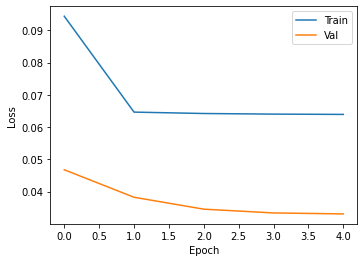

In [10]:
# Plot training curves
# hist = history.history
hist = pd.read_csv(result_dir + '/history.csv')

plt.figure(figsize=(11/2, 4))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.legend(["Train", "Val"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Getting Latent Space Representation
### train, test and dev

In [5]:
# Loading the trained model

from keras.models import load_model

picked_epock = 4

trained_cae = load_model(result_dir + '/model.h5')
trained_cae.load_weights(result_dir + f'/weights{picked_epock:04d}.h5')
for i in range(len(trained_cae.layers)):
    if ('encode' in trained_cae.layers[-1].name) or ('pooling' in trained_cae.layers[-1].name):
        break
    trained_cae.pop()
trained_cae.add(layers.Flatten())
trained_encoder = trained_cae
trained_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 128, 128, 128, 32) 2624      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 128, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 32, 32, 32, 32)    0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 32, 32, 32, 32)    27680     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 8, 8, 32)       0

In [9]:
trained_encoder.save(result_dir + '/encoder.h5', include_optimizer=False)
trained_encoder.save_weights(result_dir + '/encoder_weights.h5')

In [12]:
with tf.device(gpu_device):
    X_all = []
    y_all = []
    for generator in [train_generator, test_generator, dev_generator]:
        X = trained_encoder.predict(
            generator,
            steps=len(generator),
            verbose=1,
            max_queue_size=10,
        )
        X_all.append(np.array(X))
        y_all.append(generator.get_labels())
X_train, X_test, X_dev = X_all
y_train, y_test, y_dev = y_all
del X
save_var((X_all, y_all), result_dir + f'/Xy_all_epoch{picked_epock:04d}.pkl')

756/756 [==============================] - 41s 54ms/step


### Electrode and thermoelectric materials

In [13]:
df_cs = pd.read_csv(data_path + '/data_sets/electrode_thermoelectric_materials.csv')
cs_generator = image_generator.ImageGeneratorDataFrame(df_cs)

util_tf.random_seed(random_state)
with tf.device(gpu_device):
    X_cs = trained_encoder.predict(
        cs_generator, 
        steps=len(cs_generator),
        verbose=1,
        max_queue_size=10,
    )
# X_cs = ss.transform(X_cs)
# X_cs = pca.transform(X_cs)
y_cs = cs_generator.get_labels()
save_var((X_cs, y_cs), result_dir + f'/Xcs_epoch{picked_epock:04d}.pkl')

2569/2569 [==============================] - 127s 49ms/step


## Training the classifier
### Preparation

In [14]:
imp.reload(ml_tools)
X_all, y_all = load_var(result_dir + f'/Xy_all_epoch{picked_epock:04d}.pkl')
X_train, X_test, X_dev = X_all
y_train, y_test, y_dev = y_all

mlp_clf = ml_tools.ClassifierType1(
    clf=MLPClassifier(hidden_layer_sizes=tuple([mlp_nodes_p_layer] * 3), max_iter=500, random_state=random_state),
    result_dir=result_dir + f'/mlp_clf_epoch{picked_epock:04d}',
    ss=None,
    pca=None
)

rf_clf = ml_tools.ClassifierType1(
    clf=RandomForestClassifier(max_depth=8, random_state=random_state, n_estimators=50, n_jobs=4),
    result_dir=result_dir + f'/rf_clf_epoch{picked_epock:04d}',
    ss=None,
    pca=None
)

### Training

In [15]:
for clf in [mlp_clf, rf_clf]:
    X_all, y_all = load_var(result_dir + f'/Xy_all_epoch{picked_epock:04d}.pkl')
    X_train, X_test, X_dev = X_all
    y_train, y_test, y_dev = y_all
    X_cs, y_cs = load_var(result_dir + f'/Xcs_epoch{picked_epock:04d}.pkl')
    
    clf.fit(X_train, y_train)
    clf.predict_proba(X=X_test, y_true=y_test, set_name='test')
    clf.predict_proba(X=X_dev, y_true=y_dev, set_name='dev')
    clf.predict_proba(X=X_cs, y_true=y_cs, set_name='cs')
    save_var(clf, clf.result_dir + '/classifier_class.pkl')
# print(mlp_clf)
# print('\n')
# print(rf_clf)

### Results

In [16]:
# mlp_clf = load_var(result_dir + f'/mlp_clf/classifier_class.pkl')
# rf_clf = load_var(result_dir + f'/rf_clf/classifier_class.pkl')

In [17]:
print('MLP')
display(mlp_clf.get_stats())
print('RF')
display(rf_clf.get_stats())

MLP


,roc_auc,acc,acc_pos,acc_neg,acc_05,precision,recall,threshold,set
0,0.997818,99.112022,98.292350,99.931694,99.112022,0.999306,0.982923,0.5,train
1,0.967904,91.851852,94.308036,79.891304,91.851852,0.958050,0.943080,0.5,test
2,0.979634,93.650794,95.781250,81.896552,93.650794,0.966877,0.957812,0.5,dev
3,NaN,86.103542,NaN,NaN,86.103542,NaN,NaN,0.5,cs


RF


,roc_auc,acc,acc_pos,acc_neg,acc_05,precision,recall,threshold,set
0,0.999905,99.112022,98.292350,99.931694,99.112022,0.999306,0.982923,0.5,train
1,0.967567,92.962963,95.200893,82.065217,92.962963,0.962754,0.952009,0.5,test
2,0.979364,94.444444,96.093750,85.344828,94.444444,0.973101,0.960938,0.5,dev
3,NaN,84.157260,NaN,NaN,84.157260,NaN,NaN,0.5,cs


### ROC

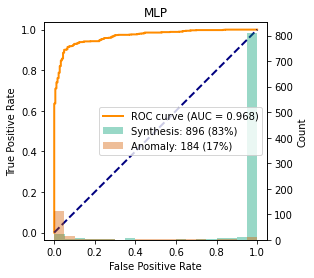

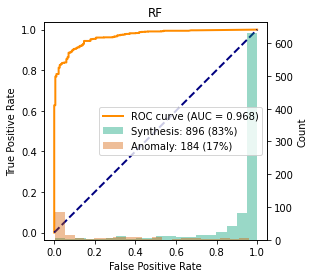

In [18]:
ml_tools.plot_roc_curve(y=mlp_clf.predictions['test']['y_true'], yp=mlp_clf.predictions['test']['yp_proba'])
plt.title(mlp_clf.label)
plt.show()

ml_tools.plot_roc_curve(y=mlp_clf.predictions['test']['y_true'], yp=rf_clf.predictions['test']['yp_proba'])
plt.title(rf_clf.label)
plt.show()

## Results on electrodes and thermoelectric materials
### Preparing

In [27]:
df_cs = pd.read_csv(data_path + '/data_sets/electrode_thermoelectric_materials.csv')
df = df_cs
df['yp_mlp'] = mlp_clf.predictions['cs']['yp_proba']
df['ypl_mlp'] = mlp_clf.predictions['cs']['yp_label']

df['yp_rf'] = rf_clf.predictions['cs']['yp_proba']
df['ypl_rf'] = rf_clf.predictions['cs']['yp_label']

df.to_csv(result_dir + '/cs_predictions.csv', index=False)
df_cs = df
# df

### Electrode materials

In [20]:
#plots_tools.plot_electrode_thermoelectric_distribution??

Data set cod size = 264
Data set mp size = 1,824


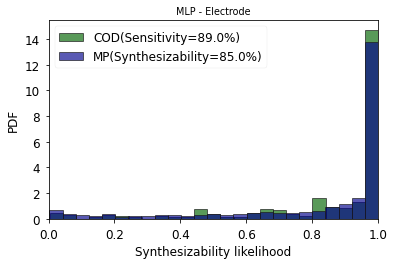

In [25]:
# df_cs = pd.read_csv(clf.result_dir + '/cs_predictions.csv')

df = df_cs[df_cs['type']=='electrode'].rename(columns={'yp_mlp': 'yp', 'ypl_mlp': 'ypl'})
plots_tools.plot_electrode_thermoelectric_distribution(df, title='MLP - Electrode')

# df = df_cs[df_cs['type']=='electrode'].rename(columns={'yp_rf': 'yp', 'ypl_rf': 'ypl'})
# plots_tools.plot_electrode_thermoelectric_distribution(df, title='RF - Electrode')

### Thermoelectric

Data set cod size = 56
Data set mp size = 66


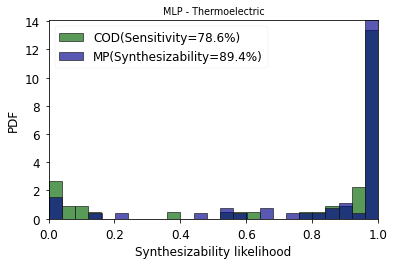

Data set cod size = 56
Data set mp size = 66


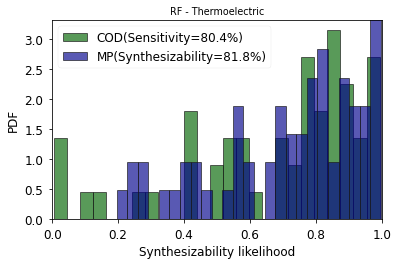

In [22]:
# df_cs = pd.read_csv(result_dir + '/cs_predictions.csv')

df = df_cs[df_cs['type']=='thermoelectric'].rename(columns={'yp_mlp': 'yp', 'ypl_mlp': 'ypl'})
plots_tools.plot_electrode_thermoelectric_distribution(df, title='MLP - Thermoelectric')

df = df_cs[df_cs['type']=='thermoelectric'].rename(columns={'yp_rf': 'yp', 'ypl_rf': 'ypl'})
plots_tools.plot_electrode_thermoelectric_distribution(df, title='RF - Thermoelectric')

## Saving the notebook and release GPU

In [23]:
util_tf.tf_reset_gpu() # Releasing allocated GPUs
tot_time_2 = datetime.now()
print('End of the training. Run time:', str(tot_time_2-tot_time_1)[:-7])

End of the training. Run time: 0:40:06


In [ ]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();')) # Saving the notebook
!cp $notebook_filename $result_dir/
!jupyter nbconvert $notebook_filename --to html --output-dir $result_dir

# Saving other python files into a tarfile
import tarfile
with tarfile.open(f'{result_dir}/codes.tar', "w") as tar:
    py_files = list_all_files('./', pattern='*.py', recursive=False)
    py_files += list_all_files('./utility/', pattern='*.py', recursive=False)
    for f in py_files:
        tar.add(f, arcname=os.path.basename(f))
display(Javascript('IPython.notebook.save_checkpoint();')) # Saving the notebook

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook train_cae_mlp_d9_encoder_9.ipynb to html
[NbConvertApp] Writing 765939 bytes to results/train_cae_mlp/encoder_9/train_cae_mlp_d9_encoder_9/train_cae_mlp_d9_encoder_9.html
